# MobileNet

Lightweight Model được hiểu đơn giản là những model gọn nhẹ (mô hình có tham số ít hơn giúp kích thước của model nhỏ hơn, mô hình ít phép tính cộng trừ nhân chia hơn làm độ phức tạp của mô hình nhỏ hơn) -> có thể ứng dụng cho các thiết bị yếu.

-> sử dụng các mô hình trên các edge device (một số có GPU nhưng hiệu quả của nó khô g đáp ứng được hay không bằng CPU trên máy tính) hoặc chạy trên các thiết bị di động (Thứ mà ngày càng phổ biến trong thời điểm hiện tại).

-> Nhu cầu về các mô hình nhỏ, nhẹ, nhanh và độ chính xác có thể chấp nhận được

## MobileNetv1

Paper Gốc: [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/abs/1704.04861)


Ở đây MobileNet có điểm cải tiến với Depthwise Separable Convolution (Tích chập tách biệt chiều sâu)
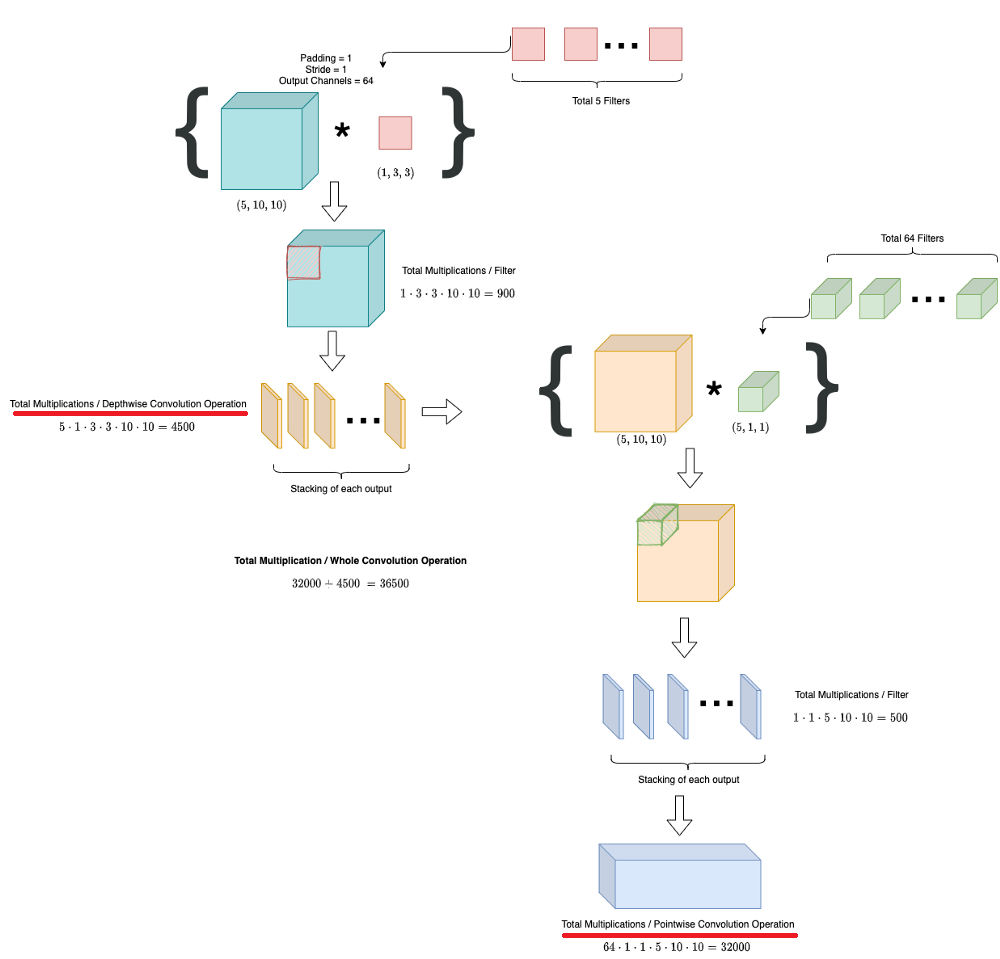


Có một nhận định chúng ta có thể nhận thấy rằng độ sâu là một trong những nguyên nhân chính dẫn đến sự gia tăng số lượng tham số của mô hình. Tích chập tách biệt chiều sâu sẽ tìm cách để loại bỏ sự phụ thuộc vào đô sâu khi tích chập mà vẫn tạo ra được một output shape có kích thước tương đương so với tích chập thông thường. Quá trình này được tách ra làm hai phần: **Deepwise Convolution** and **Pointwise Convolution**

- Tích chập chiều sâu (Depthwise Convolution): Chúng ta sẽ chia khối input tensor3D thành những lát cắt ma trận theo độ sâu. Thực hiện tích chập như hình bên dưới.

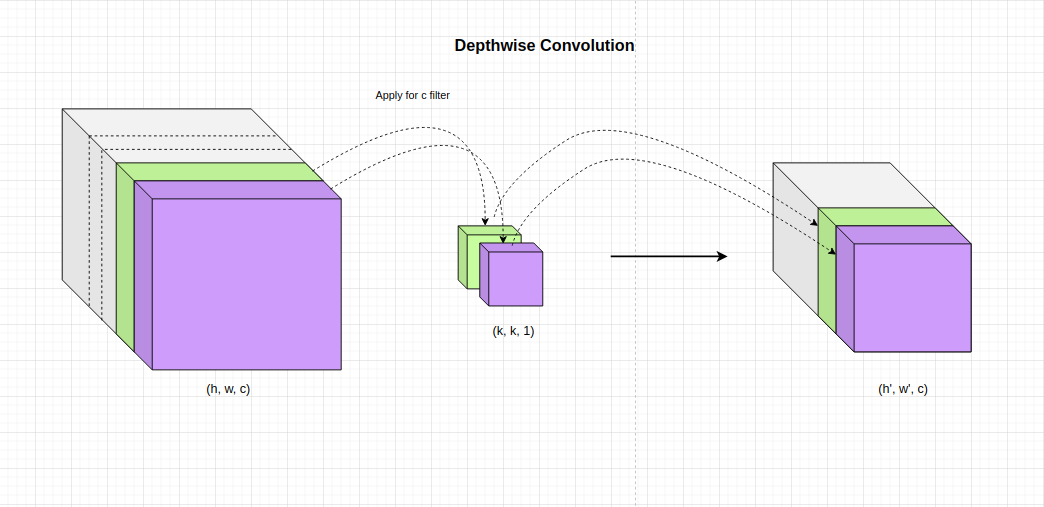

Ta có thể nhìn thấy rằng mỗi một channel sẽ được áp dụng một bộ lọc khác nhau và hoàn toàn không chia sẻ tham số. Điều này có ba tác dụng chính cho mô hình:

    - Nhận diện đặc trưng: Quá trình học và nhận diện đặc trưng được tách biệt theo từng bộ lọc. Nếu đặc trưng trên các channels là khác nhau thì sử dụng các bộ lọc riêng cho các channels sẽ chuyên biệt hơn trong viẹc phát hiện các đặc trưng. Chẳng hạn như đầu vào là ba kênh RGB thì mỗi kênh áp dụng một bộ lọc khác nhau chuyên biệt.

    - Giảm thiểu khối lượng tính toán: Để tạo ra một điểm pixel trên output thì tích chập thông thường cần sử dụng phép tính trong khi tích chập chiều sâu tách biệt chỉ cần k x k phép tính.

    - Giảm thiếu số lượng tham số

Kết quả sau tích chập được concatenate lại theo độ sâu.

- Tích chập điểm (Pointwise Convolution): Có tác dụng thay đổi độ sâu của output bước trên từ sang . Chúng ta sẽ áp dụng bộ lọc kích thước . Như vậy kích thước width và height không thay đổi mà chỉ độ sâu thay đổi

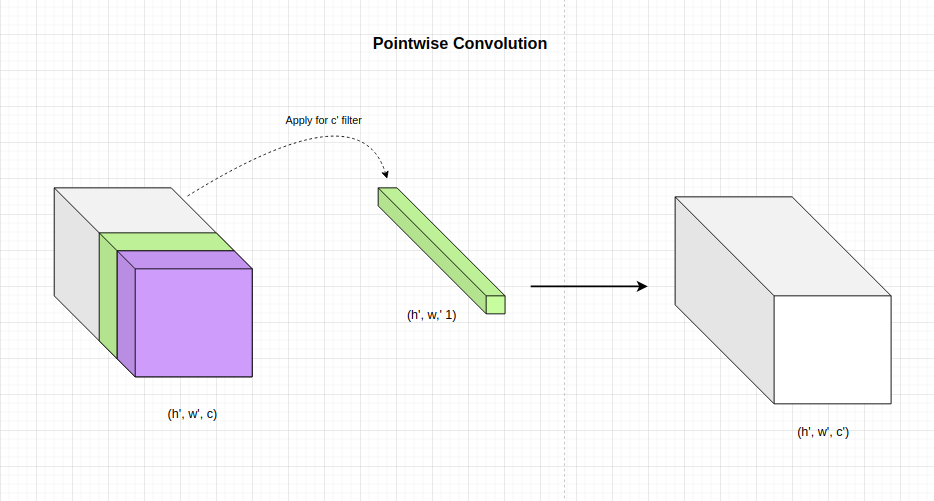



In [ ]:
import torch.nn as nn
from torchsummary import summary

class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
import torch.nn as nn
from torchsummary import summary

def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=1000):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x

